# 0. File Setup

In [1]:
%load_ext rpy2.ipython

In [28]:
# Import required Python packages

import numpy as np
import pandas as pd
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable  
import matplotlib
import scipy
from scipy.interpolate import interp1d
import sys
import scipy.interpolate
matplotlib.use('agg')
from collections import Counter
import scipy.stats as stats
from pylab import *
rcParams['legend.numpoints'] = 1
from matplotlib.ticker import MaxNLocator
import time
from rpy2.rinterface import rternalize
import rpy2.robjects
import warnings
warnings.filterwarnings('ignore')
from rpy2.robjects import r, pandas2ri
from matplotlib import lines
import sklearn.linear_model

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = [
    r'\usepackage{wasysym}',
    r'\usepackage{textcomp}']

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 1200

import warnings
warnings.filterwarnings('ignore')


%matplotlib inline

pandas2ri.activate()

In [3]:
rpy2.rinterface.initr()

In [4]:
%%R
# Import required R packages
library(easyNCDF)
library(schoolmath)
library(fields)
library(sp)
library(grid)
library(RColorBrewer)
library(ncdf4)
library(ggplot2)
library(plotly)
library(data.table)
library(Deriv)
library(RMThreshold)
library(Matrix)
library(doParallel)
library(abind)
library(plyr)
library(reticulate)


R[write to console]: Loading required package: spam

R[write to console]: Loading required package: dotCall64

R[write to console]: Loading required package: grid

R[write to console]: Spam version 2.5-1 (2019-12-12) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.

R[write to console]: 
Attaching package: ‘spam’


R[write to console]: The following objects are masked from ‘package:base’:

    backsolve, forwardsolve


R[write to console]: Loading required package: maps

R[write to console]: See https://github.com/NCAR/Fields for
 an extensive vignette, other supplements and source code 

R[write to console]: 
Attaching package: ‘plotly’


R[write to console]: The following object is masked from ‘package:ggplot2’:

    last_plot


R[write to console]: The following object is masked from ‘package:stats’:

    fil

In [5]:
# Define the d13C contour characterisics
cmap = 'gist_rainbow'
d13C_color_min = -0.5
d13C_color_max = 1.25

# 1.0 Functions for sorting cores

In [6]:

def pl_cores(minn, maxx):

    names = ['Core', 'Location', 'Lat', 'Lon', 'Dep']

    # Read in the data
    indopac = pd.read_table("../Moving_water_mass/Data/Core_files/indopac_core_data_LS16.txt", delimiter = ',', names = names)
    atl = pd.read_table("../Moving_water_mass/Data/Core_files/atl_core_data_LS16.txt", delimiter = ',', names = names)
    add = pd.read_table("../Moving_water_mass/Data/Core_files/Additional_core_locations.txt", delimiter = ',', usecols = [0, 1, 2, 3, 4], names = names)

    # Join all into a single dataframe
    df = indopac.append(atl)
    df = df.append(add)
    df = df.reset_index(drop = True)

    df['d18O names'] = df['Core'] + '_ageLS16.txt'
    df['d13C names'] = df['Core'] + '_d13C.txt'

    # Loop over the dataset and interpolate each core
    i = 0
    results_dict = {}

    while i < df.count()[0]:

        try:
            df_d18O = pd.read_table('../Moving_water_mass/Data/Core_files/' + df.loc[i]['d18O names'], delim_whitespace = True, names = ['depth', 'age'], skip_blank_lines = True, na_values = 'NAN')
        except:
            i += 1
            continue
        try:
            df_d13C = pd.read_table('../Moving_water_mass/Data/Core_files/' + df.loc[i]['d13C names'], delim_whitespace = True, names = ['depth', 'd13C'], skip_blank_lines = True, na_values = 'NAN')
        except:
            i += 1
            continue

        df_d18O = df_d18O.dropna(subset = ['age']) 
        df_d13C = df_d13C.dropna(subset = ['d13C'])

        df_d18O = df_d18O.reset_index(drop = True)
        df_d13C = df_d13C.reset_index(drop = True)

        interp = scipy.interpolate.interp1d(df_d18O['depth'], df_d18O['age'], bounds_error = True)
        try:
            df_d13C['age'] = interp(df_d13C['depth'])
        except:
            try:
                interp2 = scipy.interpolate.interp1d(df_d18O['depth'], df_d18O['age'], bounds_error = False)
                df_d13C['age'] = interp2(df_d13C['depth'])
            except:
                i += 1
                continue

        df_d13C = df_d13C.dropna(subset = ['age'])
        df_d13C = df_d13C.reset_index(drop = True)

        df_d13C = df_d13C[df_d13C['age'] > minn]
        df_d13C = df_d13C[df_d13C['age'] < maxx]

        if len(df_d13C) > 0:
            df_results = df.drop(['d18O names', 'd13C names'], axis = 1)
            df_results = df_results.loc[df_results.index.repeat(len(df_d13C))].loc[[i]]

            df_d13C = df_d13C.drop(['depth'], axis = 1)

            df_results = df_results.reset_index(drop = True).join(df_d13C.reset_index(drop = True))
            results_dict.update({
                df_results.Core[0] : df_results.drop(['Core'], axis = 1)
            })

        i += 1
        
    df_results = pd.concat(results_dict).reset_index()
    df_results = df_results.rename(columns = {'level_0' : 'Core'})
    df_results = df_results.drop(['level_1'], axis = 1)

    return(df_results)
    

In [7]:
# Define a function for reading and including cores that are in the Oliver compilation but not in the Peterson data set

def Oliver_cores(minn, maxx):
    import pandas as pd
    import numpy as np
    folder_location = '/srv/ccrc/data06/z5145948/Moving_water_mass/Data/Core_files/'
    file_mat = ['GeoB4403_2.txt',
             'GeoB1028_5.txt',
             'GeoB2109_1.txt',
             'GeoB3801_6.txt',
             'V22_38.txt',
             'V28_56.txt',
             'V27_20.txt',
             'RC12_339.txt',
             'V32_128.txt',
             'GIK16772_1.txt',
             'MD96_2080.txt',
             'MD06_3018.txt',
             'NEAP18K.txt',
             'KNR140_37JPC.txt']


    location = ['Atlantic,','Atlantic,','Atlantic,','Atlantic,','Atlantic,','Atlantic,','Atlantic,','Indian,','Pacific,','Atlantic,','Atlantic,','Pacific,','Atlantic,','Atlantic,']

    oliver_data = []

    i = 0

    while i < len(file_mat):
        with open(folder_location + file_mat[i]) as f:
            for line in f:
                oliver_data.append(location[i] + line)
        i += 1

    df = pd.DataFrame([sub.split(",") for sub in oliver_data])

    df.columns = ['Location','Core','Lat','Lon','Dep','Core depth','age','Species','pl1','pl2','d18O benthic','d13C']

    df = df[['Core','Location','Lat','Lon','Dep','d13C','age']]

    df['d13C'] = [i.rstrip() for i in df['d13C']]

    df = df[df['age'].astype(float) > minn]
    df = df[df['age'].astype(float) < maxx]

    ################################# other data                                                                                                                                                                                                                                  

    file_mat = ['CH69_K09.txt',
    'MD03_2664.txt',
    'MD95_2042.txt',
    'U1308.txt',
    'ODP1063.txt']

    locations = ['CH69_K09\tAtlantic\t41.75\t-47.35\t4100\t',
              'MD03_2664\tAtlantic\t57.439000\t-48.605800\t3442.0\t',
              'MD95_2042\tAtlantic\t37.799833\t-10.166500\t3146.0\t',
              'U1308\tAtlantic\t49.877760\t-24.238110\t3871.0\t',
              'ODP1063\tAtlantic\t33.683333\t-57.616667\t4584\t']

    other_data = []
    i = 0

    while i < len(file_mat):
        with open(folder_location + file_mat[i]) as f:
            for line in f:
                other_data.append(locations[i]+line)
        i += 1

    df2 = pd.DataFrame([sub.split("\t") for sub in other_data])

    df2.columns = ['Core','Location','Lat','Lon','Dep','Core Depth','age','d13C']

    df2 = df2[['Core','Location','Lat','Lon','Dep','d13C','age']]

    df2['d13C'] = [i.rstrip() for i in df2['d13C']]

    df2 = df2[df2['age'].astype(float) > minn]
    df2 = df2[df2['age'].astype(float) < maxx]

    results = pd.concat([df, df2])

    results = results[results['d13C'] != '']

    results['d13C'] = results['d13C'].astype(float)
    results['Lat'] = results['Lat'].astype(float)
    results['Lon'] = results['Lon'].astype(float)
    results['Dep'] = results['Dep'].astype(float)

    return(results)    
    

In [8]:
@rternalize
def compile_cores(minn,maxx):
    df_pl = pl_cores(minn,maxx)
    df_oliver = Oliver_cores(minn,maxx)

    ###################3 join the dataframes
    
    df_results = df_pl.append(df_oliver)

    #################### get only the atlantic cores

    df = df_results.reset_index(drop = True)
    df['Dep'] = abs(df['Dep'])

    df_atl = df[df['Location'] == 'Atlantic']
    df_atl = df_atl.reset_index(drop = True)
    df_atl['age'] = df_atl.age.astype(float)

    # Group cores into distinct slices
    cores_grouped_dict = {}
    for key,group in df_atl.groupby('Core'):
        average_core = np.mean(group)
        average_core['std'] = np.std(group)['d13C']
        average_core['count'] = len(group)

        cores_grouped_dict.update({
            key : average_core
        })
    df_atl = pd.DataFrame.from_dict(cores_grouped_dict,orient='index')    
    df_atl = df_atl.reset_index().rename(columns={'index' : 'Core'})
    
    return(rpy2.robjects.DataFrame(df_atl))

# 2.0 Model Auxillary functions

In [9]:
%%R -o hyperbolic_tangent_func -o quadratic_func
# Equations defintions

hyperbolic_tangent_func <- function(a, b, c, e, Lat, Dep) {                                                                                                                                                                                  
    ( (A_mem - N_mem) * tanh(a*Lat + b*Dep + c*Dep**2 + e)  + A_mem + N_mem)/2}

quadratic_func <- function(a, b, c, e, Lat, Dep) {
   ( e + a*Lat + b*Dep + c*Dep**2 )}


In [10]:
%%R -o split 
# Depth Division Function

split <- function(lat, dep, df_c) {
    
    dep_4 <- dep[(dep > 2050) & (dep < 4000)]                                                                                                                                                                                                                       

    deps <- data.frame('dep_4' = dep_4)
    
    for (i in seq(1, nrow(deps), 1)) {
        
        df_c1 <- df_c[df_c[,c("Lat")] > lat_1 & df_c[,c("Lat")] < lat_3 & df_c[,c("Dep")] > deps[i,'dep_4'], ]
        df_c4 <- df_c[df_c[,c("Lat")] > lat_1 & df_c[,c("Lat")] < lat_3 & df_c[,c("Dep")] > dep_3 & df_c[,c("Dep")] < deps[i,'dep_4'], ]
        
        c1.avg <- mean(unlist(df_c1['d13C']))
        c1.tot <- sum((df_c1['d13C'] - c1.avg)**2)

        c4.avg <- mean(unlist(df_c4['d13C']))
        c4.tot <- sum((df_c4['d13C'] - c4.avg)**2)
        
        deps[i, 'c4'] <- c4.tot
        deps[i, 'c1'] <- c1.tot
        deps[i, 'c.tot'] <- c1.tot + c4.tot

    }

    deps <- deps[!duplicated(deps['dep_4']), ]                                                                                                                                                                                                                                                               

    min.loc <- deps['dep_4'][deps['c.tot'] == min(unlist(deps['c.tot']))]

    if (is.null(dep_4.spec)) {
        min.loc <- tail(min.loc,n=1)
    }
    else(
        min.loc <- dep_4.spec
    )
    
    return(min.loc) }


# 3.0 Model Function

In [11]:
%%R -i quadratic_func -i hyperbolic_tangent_func -o modelling

modelling <- function(equation, dep_4, repetitions, lat, dep, df_c, df.N, df.A) {
    
########################################################## 
#     print('into modelling function')
    if (equation == 'tanh') { 
        df_c4 <- df_c

        x_coord_min_4 <- which(abs(lat - lat_1) == min(abs(lat - lat_1)))
        x_coord_max_4 <- which(abs(lat - lat_3) == min(abs(lat - lat_3)))

        y_coord_min_4 <- which(abs(dep - dep_3) == min(abs(dep - dep_3)))
        y_coord_max_4 <- which(abs(dep - 6000) == min(abs(dep - 6000)))

    }
    
    if (equation == 'quad') {    

        df_c1 <- df_c[df_c[,c("Dep")] > (dep_4-500), ]
        df_c4 <- df_c[df_c[,c("Dep")] <= (dep_4+500), ]

        x_coord_min_1 <- which(abs(lat - lat_1) == min(abs(lat - lat_1)))
        x_coord_max_1 <- which(abs(lat - lat_3) == min(abs(lat - lat_3)))

        y_coord_min_1 <- which(abs(dep - dep_4) == min(abs(dep - dep_4)))
        y_coord_max_1 <- which(abs(dep - 6000) == min(abs(dep - 6000)))

        x_coord_min_4 <- which(abs(lat - lat_1) == min(abs(lat - lat_1)))
        x_coord_max_4 <- which(abs(lat - lat_3) == min(abs(lat - lat_3)))

        y_coord_min_4 <- which(abs(dep - dep_3) == min(abs(dep - dep_3)))
        y_coord_max_4 <- which(abs(dep - dep_4) == min(abs(dep - dep_4)))
#         print(unique(df_c1$Dep))
    }
    
#################################################
    
    topography <-  (as.matrix(read.csv('Data/d13C_LOVECLIM_INTERP_hol.csv', header = FALSE)))*0 + 1

    x_coord_min_N <- which(abs(lat - lat_3) == (min(abs(lat - lat_3))))
    x_coord_max_N <- which(abs(lat - 70) == min(abs(lat - 70)))

    y_coord_min_N <- which(abs(dep - dep_3) == min(abs(dep - dep_3)))
    y_coord_max_N <- which(abs(dep - 3000) == min(abs(dep - 3000)))

    x_coord_min_A <- which(abs(lat + 60) == min(abs(lat + 60)))
    x_coord_max_A <- which(abs(lat - lat_1) == min(abs(lat - lat_1)))

    y_coord_min_A <- which(abs(dep - dep_3) == min(abs(dep - dep_3)))
    y_coord_max_A <- which(abs(dep - 6000) == min(abs(dep - 6000)))

############################################

    
    N.data.mean <<- mean(unlist(df.N['d13C']))
    A.data.mean <<- mean(unlist(df.A['d13C']))
        
    if (is.null(N.EM.spec)) {
        N_mem <<- N.data.mean
    }
    else(
        N_mem <<- N.EM.spec
    )
   
    if (is.null(A.EM.spec)) {
        N_mem <<- A.data.mean
    }
    else(
        N_mem <<- A.EM.spec
    )
        
    lat.0.N <<- lat_3
    lat.0.A <<- lat_1
    
###########################################

    N.Mem.region <- matrix(NA, nrow = dim(lat), ncol = dim(dep))
    A.Mem.region <- matrix(NA, nrow = dim(lat), ncol = dim(dep))
    statmod_mask_4 <- matrix(NA, nrow = dim(lat), ncol = dim(dep))
    statmod_mask_N <- matrix(NA, nrow = dim(lat), ncol = dim(dep))
    statmod_mask_A <- matrix(NA, nrow = dim(lat), ncol = dim(dep))

    if (equation == 'quad') {
        statmod_mask_1 <- matrix(NA, nrow = dim(lat), ncol = dim(dep))
        statmod_mask_1[x_coord_min_1:x_coord_max_1, y_coord_min_1:y_coord_max_1] <- 1 
        statmod_mask_1 <- statmod_mask_1 * topography}
    
    statmod_mask_4[x_coord_min_4:x_coord_max_4, y_coord_min_4:y_coord_max_4] <- 1 
    statmod_mask_4 <- statmod_mask_4 * topography

    N.Mem.region[x_coord_min_N:x_coord_max_N, y_coord_min_N:y_coord_max_N] <- N.data.mean 
    N.Mem.region <<- N.Mem.region * topography

    A.Mem.region[x_coord_min_A:x_coord_max_A, y_coord_min_A:y_coord_max_A] <- A.data.mean 
    A.Mem.region <<- A.Mem.region * topography

    statmod_mask_N[x_coord_min_N:x_coord_max_N, y_coord_min_N:y_coord_max_N] <- 1 
    statmod_mask_N <<- statmod_mask_N * topography

    statmod_mask_A[x_coord_min_A:x_coord_max_A, y_coord_min_A:y_coord_max_A] <- 1 
    statmod_mask_A <<- statmod_mask_A * topography
    

#######################################################

    lat.1 <- which(abs(lat - lat_1) == min(abs(lat - lat_1)))
    lat.3 <- which(abs(lat - lat_3) == min(abs(lat - lat_3)))
    
    statmod_mask_Nm <- statmod_mask_N
    statmod_mask_Am <- statmod_mask_A
    if (equation == 'quad') {statmod_mask_1m <- statmod_mask_1}
    statmod_mask_4m <- statmod_mask_4

    statmod_mask_Nm[lat.3,] <- 0
    statmod_mask_Am[lat.1,] <- 0

    statmod_mask_Nm[is.na(statmod_mask_Nm)] <- 0
    statmod_mask_Am[is.na(statmod_mask_Am)] <- 0
    if (equation == 'quad') {statmod_mask_1m[is.na(statmod_mask_1m)] <- 0}
    statmod_mask_4m[is.na(statmod_mask_4m)] <- 0
    
    if (equation == 'quad') {
        dep.4 <- which(abs(dep - dep_4) == min(abs(dep - dep_4)))
        statmod_mask_4m[,dep.4] <- 0
        total <- statmod_mask_1m + statmod_mask_4m + statmod_mask_Nm + statmod_mask_Am } else { total <- statmod_mask_4m + statmod_mask_Nm + statmod_mask_Am }
    
    total[total == 0 ] <- NA

    model_reduced_area <- total * as.matrix(read.csv('Data/d13C_LOVECLIM_INTERP_hol.csv', header = FALSE))

##################3 just the model data which is used
    
    if (equation == 'quad') {df.tot <- rbind(df.N, df.A, df_c1, df_c4)} else {df.tot <- rbind(df.N, df.A, df_c4)}

######################################################
#     print('up to modelling function')

    model_clust <- function(df, name, mask, count) {       ##########start model_clust
        
######################## 

        if (name == "AABW") {    
            output <- quadratic_func}
        
        if (name == 'Mixing' & equation == 'tanh') {
            output <- hyperbolic_tangent_func}

        if (name == 'Mixing' & equation == 'quad') {
            output <- quadratic_func}

##############################
        
        if (name == "AABW") {
            error_marker <<- 'AABW' }        
        
        if (name == 'Mixing' & equation == 'quad') {
            error_marker <<- 'NADW'}

################## Apply NLS function, running through random starting variables between -0.01 and 0.01 until it works..
        
        solver <<- 'port'
        min.fact <<- 2^(-30)
        tol <<- 1e-10 ########changed this
        sigs <<- 4
        
    success = FALSE
    while (!success) {

        nlsfit <- try(nls(d13C ~ output(a, b, c, e, Lat, Dep), df, weights = df[, 'count']**0.5, start = list(a = runif(1, min = -1, max= 1)/100, b = runif(1, min = -1, max= 1)/100, c = runif(1, min = -1, max= 0)/100, e = runif(1, min = -1, max= 1)/100), control = nls.control(minFactor = min.fact, tol = tol*100, warnOnly = TRUE), upper = list(a = 10000, b = 10000, c = 0, e = 10000)))
#                        nlsfit <- try(nls(d13C ~ output(a, b, c, e, Lat, Dep), df, start = list(a = runif(1, min = -1, max= 1)/100, b = runif(1, min = -1, max= 1)/100, c = runif(1, min = -1, max= 0)/100, e = runif(1, min = -1, max= 1)/100), control = nls.control(minFactor = min.fact, tol = tol*100, warnOnly = TRUE), upper = list(a = 10000, b = 10000, c = 0, e = 10000)))

#               nlsfit <- try(nls(d13C ~ output(a, b, c, e, Lat, Dep), df, weights = df[, 'age_weights'], start = list(a = 0, b = 0, c = 0, e = 0), control = nls.control(minFactor = min.fact, tol = tol, warnOnly = FALSE)))

            #### df[, 'count'] is sometimes called df[,'age_weights']

        if (!("try-error" %in% class(nlsfit))) {success = TRUE}
    }

####################	 

        params.to.save <- signif(data.frame(summary(nlsfit)$coeff), sigs)
        params.to.save['Std..Error'] <- params.to.save['Std..Error']/params.to.save['Estimate']
        
        a <- coef(nlsfit)['a']
        b <- coef(nlsfit)['b']
        c <- coef(nlsfit)['c']
        e <- coef(nlsfit)['e']
        
#################

        df$pred.d13C <- output(a, b, c, e , df$Lat, df$Dep)
        df$resids <- df$d13C - df$pred.d13C

        df2 <- matrix(,nrow = dim(dep), ncol = dim(lat))
        
####################
        
        for (value in seq(1,nrow(lat),1)){df2[,value] <- output(a, b, c, e, rep(lat[value], dim(dep)), dep)}
    
        df2 <- t(df2) * mask

#################### export the results

        forexport <- df2    
        forexport[ is.nan(forexport) ] <- 0
        forexport[ is.na(forexport) ] <- 0
        
        if (name == "AABW") {

            a.AABW <<- a
            b.AABW <<- b
            c.AABW <<- c
            e.AABW <<- e

        sigma.aabw <<- summary(nlsfit)$sigma
        n <<- nrow(df)

            AABW.region <<- forexport}
            
        if (name == 'Mixing') {

            a.NADW <<- a
            b.NADW <<- b
            c.NADW <<- c
            e.NADW <<- e
            
            N.Mem.region[ is.na(N.Mem.region) ] <- 0
            A.Mem.region[ is.na(A.Mem.region) ] <- 0
            
            NADW.region <<- forexport

            
            if (equation == 'quad') {

            sigma.mixing <<- (sigma.aabw * (n - 2) +  summary(nlsfit)$sigma * (nrow(df) - 2)) / (n + nrow(df) - 2)

                dep.4 <- which(abs(dep - dep_4) == min(abs(dep - dep_4)))
                NADW.region[,dep.4] <- 0

                total <- NADW.region + AABW.region } else {
                    sigma.mixing <<- summary(nlsfit)$sigma

                    lat.1 <- which(abs(lat - lat_1) == min(abs(lat - lat_1)))
                    lat.3 <- which(abs(lat - lat_3) == min(abs(lat - lat_3)))
                                                       
                    N.Mem.region[lat.3,] <- 0
                    A.Mem.region[lat.1,] <- 0    

                    total <- NADW.region + A.Mem.region + N.Mem.region }
            
            total[total == 0 ] <- NA   
        }
        return(total)
    }
    
###########3running model_clust function

    if (equation == 'tanh') {
        cluster_name <- list("Mixing")
        cluster_num <- 1 
        cluster_list <- list(df_c4)
        mask <- list(statmod_mask_4)}
    
    if (equation == 'quad') {
        cluster_name <- list("AABW", "Mixing")
        cluster_num <- 2
        cluster_list <- list(df_c1, df_c4)
        mask <- list(statmod_mask_1, statmod_mask_4) }    
    
    for (count in seq(1, cluster_num, 1)) {            
        total <- model_clust(cluster_list[[count]], cluster_name[[count]], mask[[count]], count)}

    if (equation == 'quad'){
        stats <- data.frame(sigma = sigma.mixing, N_mem = N.data.mean, A_mem = A.data.mean, a.AABW = a.AABW, b.AABW = b.AABW, c.AABW = c.AABW, e.AABW = e.AABW, a.NADW = a.NADW, b.NADW = b.NADW, c.NADW = c.NADW, e.NADW = e.NADW)
    }
        
    if (equation == 'tanh'){
        stats <- data.frame(sigma = sigma.mixing, N_mem = N.data.mean, A_mem = A.data.mean, a.AABW = NA, b.AABW = NA, c.AABW = NA, e.AABW = NA, a.NADW = a.NADW, b.NADW = b.NADW, c.NADW = c.NADW, e.NADW = e.NADW)
    }

    return(list(samples = df.tot, statmod = total, stats = stats))
}


# 4.0 Loop function over model function

In [12]:
%%R -o loop_func

loop_func <- function(input) {     

    intersect <- TRUE

    # Import the data using python
    df <- df_original
    #df <- compile_cores(input[, 'slice'][[1]][1], input[, 'slice'][[1]][2])
    
    #################  Get the cores list

    df_Hol <- compile_cores(3,5)
    df_LIG <- compile_cores(120,125)

    # Find the list of cores that are both in the Holocene and the LIG
    common_core_list <- intersect(df_Hol[,'Core'], df_LIG[,'Core'])  
    
    # Find the intersection bewteen Holocene and LIG

    if (intersect == TRUE) {
    df <- df[df$Core %in% common_core_list,]
    }

    # Get region boundaries
    params <- read.table('Data/box_params.txt', header = TRUE)
    
    if (is.null(dep_3.spec)) {
        dep_3 <<- params[params$para == 'dep_3_UVic', ]$value
    }
    else(
        dep_3 <<- dep_3.spec )
        
    if (is.null(lat_1.spec)) {
        lat_1 <<- params[params$para == 'lat_1', ]$value
    }
    else(
        lat_1 <<- lat_1.spec )
        
    if (is.null(lat_3.spec)) {
        lat_3 <<- params[params$para == 'lat_3', ]$value
    }
    else(
        lat_3 <<- lat_3.spec   )     


    # Get latitude-depth grid points
    
    #dep_grid <- abs(array(read.csv('Data/depth_levels.csv', header = FALSE)$V1))
    #lat_grid <- array(read.csv('Data/latitude_levels.csv', header = FALSE)$V1)
    
    # Divide up dataframe based on regions
    
    df_c <- df[df[,c("Lat")] > lat_1 & df[,c("Lat")] < lat_3 & df[,c("Dep")] > dep_3, ]
    df.N <- df[df[,c("Lat")] > 45 & df[,c("Lat")] < 70 & df[,c("Dep")] > dep_3 & df[,c("Dep")] < 3000 , ]
    # df.N <- df[df[,c("Lat")] > lat_3 & df[,c("Lat")] < 70 & df[,c("Dep")] > dep_3 & df[,c("Dep")] < 3000 , ]
    # df.A <- df[df[,c("Lat")] > -60 & df[,("Lat")] < lat_1 & df[,c("Dep")] > dep_3 & df[,c("Dep")] < 6000 , ]
    df.A <- df[df[,c("Lat")] > -60 & df[,("Lat")] < -40 & df[,c("Dep")] > dep_3 & df[,c("Dep")] < 6000 , ]
    
    write.csv(df.A,"AABW_cores.txt")
    write.csv(df.N,"NADW_cores.txt")
    
#     print('defined regions')
###################################   
    
    success = FALSE
    while (!success) { 

#         print('divided')
        
        if (input[, 'equation'] == 'quad' ) {
            
            attempt_rand <- try(input[, 'dep_4'] <- split(lat_grid, dep_grid, df_c))
            
        }
        if (input[,'equation'] == 'tanh' ) {
            attempt_rand <- NA
            input[, 'dep_4'] <- NA
        }
        
#         print('completed Split running func')
        
        if (!("try-error" %in% class(attempt_rand))) {
#             print('successful split function')
            
            attempt_model<- try(output <- modelling(input[, 'equation'], input[, 'dep_4'], input[, 'reps'], lat_grid, dep_grid, df_c, df.N, df.A ))

            if(!("try-error" %in% class(attempt_model))) {
#                 print('successful modelling')
                success = TRUE
            }
        }
    }

#     print('modeling complete')
        
    filename <- paste(input[, 'reps'], input[, 'equation'], sep = '_')
        
    input[, 'filename'] <- paste(filename, "d13C.txt", sep = '_')
    input[, 'success.rate'] <- success
    
    if(!success) {
        output = list()
        output$statmod <- matrix(NA, nrow = length(lat), ncol = length(dep))
        output$samples <- data.frame(NA)
        output$stats <- data.frame(sigma = NA, N_mem = NA, A_mem = NA, a.AABW = NA, b.AABW = NA, c.AABW = NA, e.AABW = NA, a.NADW = NA, b.NADW = NA, c.NADW = NA, e.NADW = NA)}

    rownames(output$stats) <- NULL
    rownames(input) <- NULL
    input <- merge(input, output$stats, by = 0)
    
    output$samples$run.no <- rep(input[,'run.no'], times = nrow(output$samples))

#     print('output made')
#     print(' ')
    
    return(list(df = input, statmod = output$statmod, samples = output$samples))
    
}


# 5.0 Model R Setup

In [13]:
%%R -i loop_func -i compile_cores

# Import all the required packages

setup_function <- function(lat_grid,dep_grid,df, time_min, time_max,
                           N.EM.spec=NULL,A.EM.spec=NULL,dep_4.spec=NULL,
                           lat_1.spec=NULL,lat_3.spec=NULL,dep_3.spec=NULL) {

    N.EM.spec <<- N.EM.spec
    A.EM.spec <<- A.EM.spec
    dep_4.spec <<- dep_4.spec
    lat_1.spec <<- lat_1.spec
    lat_3.spec <<- lat_3.spec
    dep_3.spec <<- dep_3.spec    
    
    
    lat_grid <<- lat_grid
    dep_grid <<- dep_grid
    df_original <<- df

    options(warn=-1)

    # Get information on cores for parallelisation

    # no_cores <- detectCores()
    # clust <- makeCluster(no_cores, outfile = 'log.txt')
    # registerDoParallel(clust)
    # writeLines(c(""), "log.txt")

    # Set up the conditions to model

    equation <- c('quad')

    resolution <- 1 # The number of years to move up by in each slice
    lower <- time_min
    upper <- time_max
    slice <- mapply(c, lower, upper, SIMPLIFY=FALSE)

    # Number of times to repeat the above simulations
    repetitions <- 1

    # Compile all of these setup conditions into an model input array
    input <- expand.grid(equation = equation, slice = slice, reps = repetitions)
    input$run.no <- rownames(input)

    # Create functions for extracting the different outputs from foreach function 
    acombstatmod <- function(...)  abind(...$statmod, along = 3)
    rcombdf <- function(...) rbind(...$df)
    rcombsmp <- function(...) rbind(...$samples)
    
    # Run each row in the input array in parallel
    output <- foreach(i = 1:nrow(input), .packages="foreach") %do% {loop_func(input[i,])}

    # Extract the results
    model_output <- array(as.numeric(unlist(lapply(output, acombstatmod))), dim = c(160, 120, nrow(input))) #Mean response of the statistical models
    df_results_summary <- do.call(rbind, lapply(lapply(output, rcombdf), data.frame, stringsAsFactors = FALSE)) #Summary of the statistical models
    samples <- rbind.fill(lapply(output, rcombsmp)) #Dataframe of the samples used for modelling

    # Break down time slice column into two columns, remove old 'slice' column
    time.sep <- function(...) (unlist(...))
    times <- lapply(df_results_summary['slice'], time.sep)
    lower <- times$slice[seq(1, length(times$slice), 2)]
    upper <- times$slice[seq(2, length(times$slice), 2)]
    df_results_summary$lower <- lower
    df_results_summary$upper <- upper
    drops <- c('slice')
    df_results_summary <- df_results_summary[ , !(names(df_results_summary) %in% drops)]
    
    return(list('samples'=samples, 'summary'=df_results_summary, 'output'=model_output))
    }


# 6.0 Load the data

In [14]:
# Import standardised latitudes and depths
lat_grid = np.genfromtxt('/srv/ccrc/data06/z5145948/Moving_water_mass/Data/latitude_levels.csv', delimiter=',')
dep_grid = np.genfromtxt('/srv/ccrc/data06/z5145948/Moving_water_mass/Data/depth_levels.csv', delimiter=',')

In [15]:
# Load Some UVic Data for calculating the d13C of Atlantic Basin
fh = Dataset('/srv/ccrc/data06/z5145948/UVic/PI/tavg.09920.01.01.nc')

o_dic13 = fh.variables['O_dic13'][:]
dep_U = fh.variables['depth'][:]
lon_U = fh.variables['longitude'][:]
lat_U = fh.variables['latitude'][:]

mask_U = o_dic13 / o_dic13

# #### import some UVic data

# # Set up graph

dep = dep_grid
lat = lat_grid                                                                                                                                                                                                                     

# # Adjust the mask

mask_U_original = mask_U.copy()

mask_U = np.mean(mask_U, axis = 0)

X, Y = np.meshgrid(dep_U, lat_U)
XI, YI  = np.meshgrid(dep, lat)

new_mask = np.empty((len(lon_U), len(lat), len(dep)))

for i in  np.arange(0, mask_U[0,0,:].shape[0]):
    mask_regridded_U = scipy.interpolate.griddata((X.flatten(), Y.flatten()), (mask_U[:,:,i].T).flatten() , (XI, YI),method='linear')
    new_mask[i,:,:] = mask_regridded_U

new_mask = new_mask.T
mask_U = new_mask
mask_U = np.ma.masked_where(mask_U == 0, mask_U)

mask = mask_U
lon = lon_U


# 7.0 Run Experiments

In [16]:
Hol_min = 4#3.0
Hol_max = 7#5.0
LIG_min = 120.0
LIG_max = 125.0

In [17]:
df_Hol = compile_cores(Hol_min,Hol_max)
df_LIG = compile_cores(LIG_min,LIG_max)

In [18]:
%%R -i df_Hol -i Hol_min -i Hol_max -i lat_grid -i dep_grid -o Hol_samples_d4s -o Hol_model_output_d4s -o Hol_summary_d4s
 
Hol_d4s <- setup_function(lat_grid,dep_grid,df_Hol,Hol_min,Hol_max,
                                  dep_4.spec=3500,lat_1.spec=-50,lat_3.spec=55)

Hol_samples_d4s <- Hol_d4s$samples
Hol_model_output_d4s <- Hol_d4s$output
Hol_summary_d4s <- Hol_d4s$summary


In [19]:
%%R -i df_LIG -i LIG_min -i LIG_max -i lat_grid -i dep_grid -o LIG_samples_d4s -o LIG_model_output_d4s -o LIG_summary_d4s
 
LIG_d4s <- setup_function(lat_grid,dep_grid,df_LIG,LIG_min,LIG_max,
                                  dep_4.spec=3500,lat_1.spec=-50,lat_3.spec=55)

LIG_samples_d4s <- LIG_d4s$samples
LIG_model_output_d4s <- LIG_d4s$output
LIG_summary_d4s <- LIG_d4s$summary


# 8.0 Plotting Experiments

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


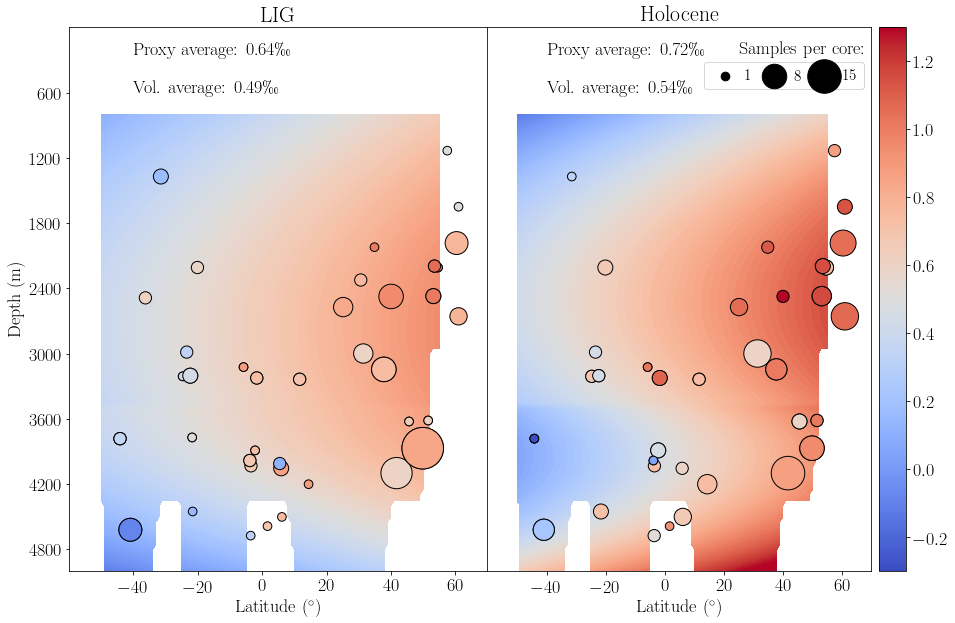

In [20]:
d13C_color_max = 1.3
d13C_color_min = -0.3
cmap= 'coolwarm'

point_size_multiplier = 75
fontsize = 18

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : fontsize}

matplotlib.rc('font', **font)

# Create the plotting function
def plotting_stat_models(summary, samples, proxy_simulations, ax):

    run = 0
    # Get the year boundaries of the subplot
    
    summary_lower = summary.reset_index(drop=True)['lower'][0] # summary[summary.index == run]['lower'].reset_index(drop = True)[0]
    summary_upper = summary.reset_index(drop=True)['upper'][0] # summary[summary.index == run]['upper'].reset_index(drop = True)[0]

    # get the samples just for this run
    run_samples = samples#samples[samples['run.no'] == run]

    # plot the statistical model
    ax.contourf(
                lat_grid,
                dep_grid,
                proxy_simulations[:,:,run].T, 
                100,
                cmap = cmap,
                vmin = d13C_color_min,
                vmax = d13C_color_max,
                zorder = -1000
                        )
    
    # plot the run proxy samples
    output = ax.scatter(run_samples['Lat'],
                run_samples['Dep'],
                c = run_samples['d13C'],
                s = run_samples['count']*point_size_multiplier,
                cmap = cmap,
                vmin = d13C_color_min,
                vmax = d13C_color_max,
                edgecolor = 'k',
                zorder=1000
                       )    

    # Average of proxies
    ax.text(-40, 250, "Proxy average: {}$\permil$".format(round(np.mean(samples['d13C']), 2)))

    # Find volume weighted average of the stat. model
    
    d13CX = np.repeat(proxy_simulations[:,:,run].T[:, :, np.newaxis], len(lon), axis=2) * mask
    d13CX = np.ma.masked_invalid(d13CX)

    wt = np.cos(np.tile(abs(lat[:,None])*np.pi/180,(1,len(lon))))
    wt2 = np.repeat(wt[np.newaxis, :, :], len(dep), axis=0)
    d13CX_avg = np.sum(d13CX * wt2 * ~d13CX.mask)/np.sum(wt2* ~d13CX.mask)
    
    ax.text(-40, 600, "Vol. average: {}$\permil$".format(round(d13CX_avg, 2)))

    # Correct the axes
    ax.set_ylim(5000,0)
    ax.set_xlim(-60,70)       

    return(output)
    
# Run the function
    
fig = plt.figure(figsize = (15, 10))

ax2 = plt.subplot2grid((1,2),(0,0))
ax1 = plt.subplot2grid((1,2),(0,1))


output = plotting_stat_models(Hol_summary_d4s, Hol_samples_d4s, np.array(Hol_model_output_d4s), ax1)
output = plotting_stat_models(LIG_summary_d4s, LIG_samples_d4s, np.array(LIG_model_output_d4s), ax2)

# Adjust axes

# Cbar
for ax in [ax1]:#,ax4]:
    divider = make_axes_locatable(ax)
    divider = divider.append_axes("right", size="7%", pad="2%")
    cbar = plt.colorbar(output,cax=divider,pad='2%')    
    
ax1.set_xlabel('Latitude ($^\circ$)')  
ax2.set_xlabel('Latitude ($^\circ$)')    

ax2.set_ylabel('Depth (m)')
ax1.set_yticks([])

ax2.set_title('LIG')
ax1.set_title('Holocene')

ax1.get_xaxis().set_major_locator(MaxNLocator(nbins=8,prune='both'))
ax2.get_xaxis().set_major_locator(MaxNLocator(nbins=8,prune='both'))
ax2.get_yaxis().set_major_locator(MaxNLocator(nbins=9,prune='both'))

# Make a legend

s1 = ax1.scatter([],[],s=[1*point_size_multiplier],marker='o',c='k')
s2 = ax1.scatter([],[],s=[8*point_size_multiplier],marker='o',c='k')
s3 = ax1.scatter([],[],s=[15*point_size_multiplier],marker='o',c='k')

ax1.legend([s1,s2,s3],[1,8,15]
           ,ncol=3,handletextpad=0.3,columnspacing=0.5,bbox_to_anchor=[1,0.95,0,0],fontsize=15)
ax1.text(x=25,y=250,s='Samples per core:')

# Plot
    
plt.subplots_adjust(wspace = 0, hspace = 0.4)    

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : fontsize}

matplotlib.rc('font', **font)

plt.savefig('../LIG/Figures/d13C_statistical_reconstruction_redone.png',bbox_inches='tight',dpi=500)

plt.show()


In [21]:
caption = [
    'Reconstruction of 2-dimensional $\delta^{13}$C ($\permil$)',
    'during the Holocene and LIG of depth with latitude for the Atlantic Ocean.',
    'The points represent the proxy data, showing the average $\delta^{13}$C with colour and size indicating the number of points.',
    'Contours show the reconstructed $\delta^{13}$C.'
]

caption = ' '.join(caption)

# Write to a file
file1 = open("../LIG/Figures/d13C_statistical_reconstruction_caption.tex","w") 
file1.write(caption) 
file1.close() #to change file access modes


# Latitude Analysis

## Plot statistical model results

In [22]:
stat_model_ocean_depth = 2000

In [23]:
%%R -i Hol_summary_d4s -i LIG_summary_d4s -o d13c_latitude_Hol -o d13c_latitude_LIG -o Lat -i stat_model_ocean_depth

Ocean_depth <- stat_model_ocean_depth
Lat <- seq(-40,60,5)

equation <- dget("/srv/ccrc/data06/z5145948/Moving_water_mass/form_NADW_quad.R")

# Holocene
a <- Hol_summary_d4s$a.NADW
b <- Hol_summary_d4s$b.NADW
c <- Hol_summary_d4s$c.NADW
e <- Hol_summary_d4s$e.NADW
d13c_latitude_Hol <- equation(a, b, c, e, Lat, Ocean_depth)

# LIG
a <- LIG_summary_d4s$a.NADW
b <- LIG_summary_d4s$b.NADW
c <- LIG_summary_d4s$c.NADW
e <- LIG_summary_d4s$e.NADW
d13c_latitude_LIG <- equation(a, b, c, e, Lat, Ocean_depth)

## Moving Average

In [24]:
# Drop the duplicated rows

Hol_samples_d4s = Hol_samples_d4s.drop_duplicates()
LIG_samples_d4s = LIG_samples_d4s.drop_duplicates()

In [25]:
# Create a depth bound subset for plotting
Hol_samples_d4s_subset = Hol_samples_d4s[Hol_samples_d4s.Dep < 3000]
LIG_samples_d4s_subset = LIG_samples_d4s[LIG_samples_d4s.Dep < 3000]

In [26]:
window = 15
lat_range_min = list(np.arange(-40,70,1))
lat_range_max = lat_range_min[window:] + [70]

moving_average_Hol = {}
for lat_1, lat_2 in zip(lat_range_min,lat_range_max):
    moving_average_Hol.update({
        lat_1 : np.mean(Hol_samples_d4s_subset[(Hol_samples_d4s_subset.Lat > lat_1) & (Hol_samples_d4s_subset.Lat < lat_2)])
    })

df_moving_average_Hol = pd.DataFrame.from_dict(moving_average_Hol,orient='index')          

moving_average_LIG = {}
for lat_1, lat_2 in zip(lat_range_min,lat_range_max):
    moving_average_LIG.update({
        lat_1 : np.mean(LIG_samples_d4s_subset[(LIG_samples_d4s_subset.Lat > lat_1) & (LIG_samples_d4s_subset.Lat < lat_2)])
    })

df_moving_average_LIG = pd.DataFrame.from_dict(moving_average_LIG,orient='index')          


## Plot

In [30]:

fontsize = 24

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : fontsize}

matplotlib.rc('font', **font)

fig = plt.figure(figsize=(20,10))

ax1 = subplot2grid((1,2),(0,0))
ax2 = subplot2grid((1,2),(0,1))

# Plot the d13C values for each core relative to latitude

####

ax1.scatter(Hol_samples_d4s_subset.Lat, Hol_samples_d4s_subset.d13C,c='r')
ax1.scatter(LIG_samples_d4s_subset.Lat, LIG_samples_d4s_subset.d13C,c='b')

# ax1.scatter(60,Hol_summary_d4s.N_mem,marker='*',c='r',s=300)
# ax1.scatter(-40,Hol_summary_d4s.A_mem,marker='*',c='r',s=300)

# ax1.scatter(60,LIG_summary_d4s.N_mem,marker='*',c='b',s=300)
# ax1.scatter(-40,LIG_summary_d4s.A_mem,marker='*',c='b',s=300)

ax1.plot(df_moving_average_Hol.index, df_moving_average_Hol.d13C,'r--')
ax1.plot(df_moving_average_LIG.index, df_moving_average_LIG.d13C,'b--')

ax1.plot(Lat,d13c_latitude_Hol,c='r')
ax1.plot(Lat,d13c_latitude_LIG,c='b')

### Relative to end members

df_samples_EM_frac_Hol = [float(1-(Hol_summary_d4s.N_mem - x)/(Hol_summary_d4s.N_mem - Hol_summary_d4s.A_mem))
     for x in Hol_samples_d4s.d13C]

df_samples_EM_frac_LIG = [float(1-(LIG_summary_d4s.N_mem - x)/(LIG_summary_d4s.N_mem - LIG_summary_d4s.A_mem))
     for x in LIG_samples_d4s.d13C]

########## orginal graph code

# ax2.scatter(Hol_samples_d4s_subset.Lat, df_samples_EM_frac_Hol,c='r')
# ax2.scatter(LIG_samples_d4s_subset.Lat, df_samples_EM_frac_LIG,c='b')

#########

ax2.scatter(Hol_samples_d4s.Lat, df_samples_EM_frac_Hol,c='r')
ax2.scatter(LIG_samples_d4s.Lat, df_samples_EM_frac_LIG,c='b')

reg = sklearn.linear_model.LinearRegression().fit(np.array(Hol_samples_d4s.Lat).reshape(-1, 1),df_samples_EM_frac_Hol)
Y = reg.predict(np.array(Hol_samples_d4s.Lat).reshape(-1, 1))
ax2.plot(np.array(Hol_samples_d4s.Lat),Y,c='r',linestyle='-')

reg = sklearn.linear_model.LinearRegression().fit(np.array(LIG_samples_d4s.Lat).reshape(-1, 1),df_samples_EM_frac_LIG)
Y = reg.predict(np.array(LIG_samples_d4s.Lat).reshape(-1, 1))
ax2.plot(np.array(LIG_samples_d4s.Lat),Y,c='b',linestyle='-')

##########

ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')

ax1.set_ylabel('$\delta^{13}$C ($\permil$)')
ax2.set_ylabel('End member fraction')

ax2_xlims = ax2.get_xlim()
ax2.plot(ax2_xlims,[0,0],'k--',zorder=-100)
ax2.plot(ax2_xlims,[1,1],'k--',zorder=-100)
ax2.text(ax2_xlims[0]+0.05*np.diff(ax2_xlims),0.05,'AABW End-member')
ax2.text(ax2_xlims[0]+0.05*np.diff(ax2_xlims),1.05,'NADW End-member')
ax2.set_xlim(ax2_xlims)

ax1.set_xlabel('Latitude ($^{\circ}$)')
ax2.set_xlabel('Latitude ($^{\circ}$)')

ax1.text(ax1.get_xlim()[1]-0.05*np.diff(ax1.get_xlim()),
         ax1.get_ylim()[0]+0.05*np.diff(ax1.get_ylim()),
         'a)')
ax2.text(ax2.get_xlim()[1]-0.05*np.diff(ax2.get_xlim()),
         ax2.get_ylim()[0]+0.05*np.diff(ax2.get_ylim()),
         'b)')

LIG_leg = ax1.scatter([],[],marker='o',c='b')
Hol_leg = ax1.scatter([],[],marker='o',c='r')
core_leg = ax1.scatter([],[],marker='o',c='k')
EM_leg = ax1.scatter([],[],marker='*',c='k',s=100)
stat_leg = lines.Line2D([0,0],[0,0],c='k',linestyle='-')
moving_leg = lines.Line2D([0,0],[0,0],c='k',linestyle='--')

plt.legend([LIG_leg, Hol_leg, core_leg, EM_leg, stat_leg, moving_leg],
           ['LIG','Holocene','core','End-member','Statistical Model', 'Moving Average'],
          loc='best', bbox_to_anchor=(-0.6, -0.2, 0.5, 0.5),fontsize=15)

plt.subplots_adjust(wspace = 0.1, hspace = 0.2)  

# plt.suptitle('North-South $\delta^{13}$C Atlantic Profile')


font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : fontsize}

matplotlib.rc('font', **font)

plt.savefig('../LIG/Figures/Atlantic_profile_redone.png',bbox_inches='tight',dpi=500)

plt.show()

In [ ]:
samples_EM_frac_Hol_array = np.array(df_samples_EM_frac_Hol)
samples_EM_frac_LIG_array = np.array(df_samples_EM_frac_LIG)

In [ ]:
%%R -i Hol_samples_d4s -i LIG_samples_d4s -i samples_EM_frac_LIG_array -i samples_EM_frac_Hol_array -o LIG_model -o Hol_model

df_Hol <- data.frame('Lat'=Hol_samples_d4s$Lat,'d13C_EM_frac'=samples_EM_frac_Hol_array)
df_LIG <- data.frame('Lat'=LIG_samples_d4s$Lat,'d13C_EM_frac'=samples_EM_frac_LIG_array)

my_func <- function(a,b,Lat) {
    a*Lat + b
}

Hol_model = nls(d13C_EM_frac ~ my_func(a, b, Lat), df_Hol, start = list(a = 1, b = 0))
LIG_model = nls(d13C_EM_frac ~ my_func(a, b, Lat), df_LIG, start = list(a = 1, b = 0))

Hol_model <- coef(Hol_model)
LIG_model <- coef(LIG_model)

Hol_model['a']


In [ ]:

from scipy import stats

df_samples_EM_frac_Hol = sort(df_samples_EM_frac_Hol)
df_samples_EM_frac_LIG = sort(df_samples_EM_frac_LIG)

counts, bins = np.histogram(df_samples_EM_frac_Hol,bins=np.arange(-0.5,2.0,0.2))
plt.hist(bins[:-1], bins, weights=counts,alpha=0.5,color='r')

# kde = stats.gaussian_kde(np.array(df_samples_EM_frac_Hol['1']))
# kde_curve = np.linspace(np.min(df_samples_EM_frac_Hol), np.max(df_samples_EM_frac_Hol), len(np.array(df_samples_EM_frac_Hol['1'])))
# kde_curve = [x[0] for x in kde_curve]

# plt.plot(kde_curve, kde(kde_curve),c='r')

counts, bins = np.histogram(df_samples_EM_frac_LIG,bins=np.arange(-0.5,2.0,0.2))
plt.hist(bins[:-1], bins, weights=counts,alpha=.5,color='b')

# kde = stats.gaussian_kde(np.array(df_samples_EM_frac_LIG['1']))
# kde_curve = np.linspace(np.min(df_samples_EM_frac_LIG), np.max(df_samples_EM_frac_LIG), len(np.array(df_samples_EM_frac_LIG['1'])))
# kde_curve = [x[0] for x in kde_curve]

# plt.plot(kde_curve, kde(kde_curve),c='b')

plt.show()

In [ ]:
import sklearn.linear_model




In [31]:
LIG_summary_d4s.A_mem

1    0.139643
Name: A_mem, dtype: float64

In [32]:
LIG_summary_d4s.N_mem

1    0.792636
Name: N_mem, dtype: float64

In [33]:
Hol_summary_d4s.A_mem

1   -0.035
Name: A_mem, dtype: float64

In [34]:
Hol_summary_d4s.N_mem

1    1.023397
Name: N_mem, dtype: float64

In [35]:
Hol_summary_d4s

,Row.names,equation,reps,run.no,dep_4,filename,success.rate,sigma,N_mem,A_mem,a.AABW,b.AABW,c.AABW,e.AABW,a.NADW,b.NADW,c.NADW,e.NADW,lower,upper
1,1,quad,1.0,1,3500.0,1_quad_d13C.txt,1,0.282812,1.023397,-0.035,0.008485,-0.004281,5.419169e-07,8.930765,0.006989,0.000929,-1.840961e-07,-0.399555,4,7


In [36]:
LIG_summary_d4s

,Row.names,equation,reps,run.no,dep_4,filename,success.rate,sigma,N_mem,A_mem,a.AABW,b.AABW,c.AABW,e.AABW,a.NADW,b.NADW,c.NADW,e.NADW,lower,upper
1,1,quad,1.0,1,3500.0,1_quad_d13C.txt,1,0.203262,0.792636,0.139643,0.004801,0.001359,-1.997406e-07,-1.677598,0.005319,0.000418,-7.526551e-08,0.080998,120.0,125.0


In [ ]:
df_samples_EM_frac_Hol

In [ ]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(41)

N = 100
x = np.random.randint(0, 9, N)
bins = np.arange(10)

kde = stats.gaussian_kde(x)
xx = np.linspace(0, 9, 1000)
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(x, normed=True, bins=bins, alpha=0.3)
ax.plot(xx, kde(xx))

plt.show()

In [ ]:
np.random.randint(0, 9, N)